In [31]:
import pandas as pd

df = pd.read_csv('../data/onehot.csv')
df.drop('Name', axis=1, inplace=True)
# df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(1100, 1673)


,Class,sodium,extract,alcohol,water,glycerin,glycol,acid,dimethicone,fragrance,...,tomato,pyrus,tromethamine,hedera,helix,fillers,proprietary,microcapsules,https,pinterest
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.3, random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [34]:
import numpy as np

cov_mat = np.cov(X_train_std.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

eigen_vals.shape, eigen_vecs.shape

((1672,), (1672, 1672))

c:\Python 3.7\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
c:\Python 3.7\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


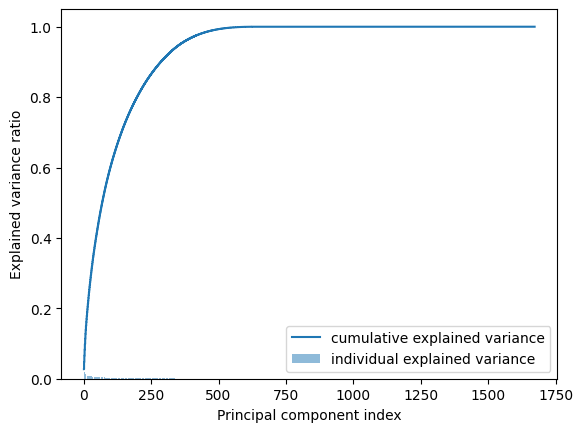

In [35]:
import matplotlib.pyplot as plt

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,1673), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,1673), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [36]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)



In [37]:
# projection matrix W from the top two eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.02362041+0.j  0.06851501+0.j]
 [-0.02353147+0.j  0.0450878 +0.j]
 [-0.01134645+0.j  0.06900014+0.j]
 ...
 [-0.00029078+0.j  0.00636983+0.j]
 [ 0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j]]


In [38]:
#Input Training dataset for PCA
X_train_pca = X_train_std.dot(w)

c:\Python 3.7\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


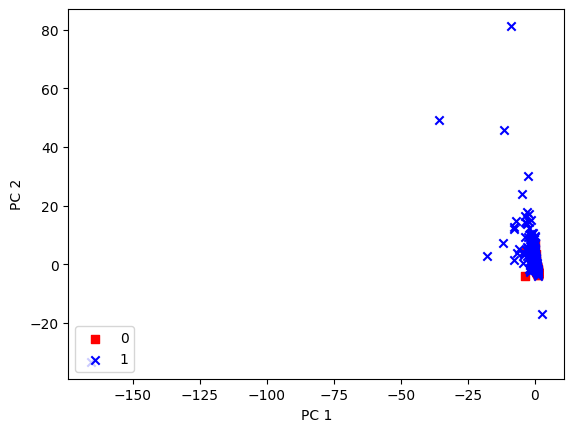

In [39]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [40]:
# lr for classification:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# intialize pca and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

LogisticRegression(solver='liblinear')

C:\Users\HP\AppData\Local\Temp\ipykernel_14032\1079956100.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


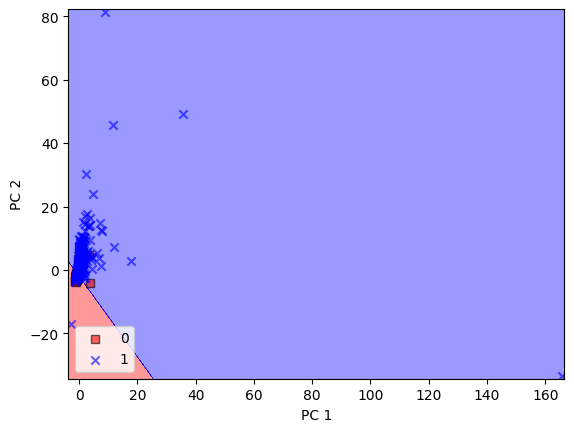

In [41]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)# plot decision regions for training set


plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()